In [1]:
# import and set up fastbook

# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
import os

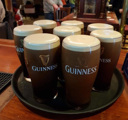

In [5]:
#Checking an image

dest = 'images/guinness/good/1.jpg'
im = Image.open(dest)
im.to_thumb(128,128)

In [57]:
#identifying the categories and defining the path

guinness_types = 'good','bad'
path = Path('images/guinness')

## From Data to DataLoaders

In [58]:
#using fastais DataLoader to prepare the data
# Identify dependent and independent variables
# Use 20% for validation
# Resize the images to 128px

pints = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [59]:
dls = pints.dataloaders(path)

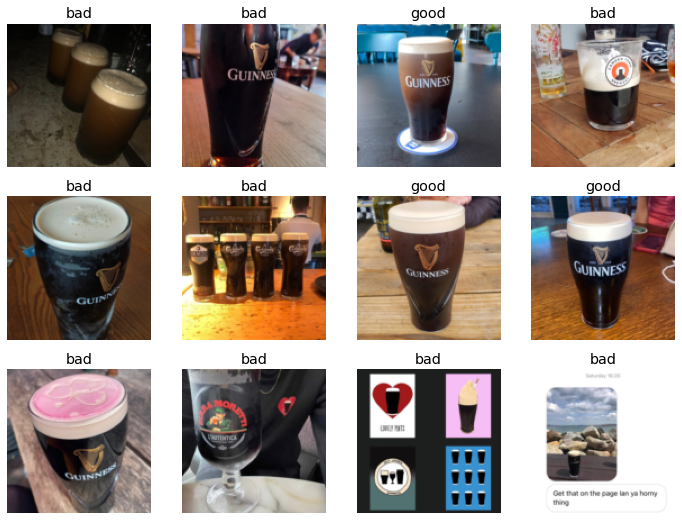

In [60]:
dls.valid.show_batch(max_n=12, nrows=3)

### Data Augmentation

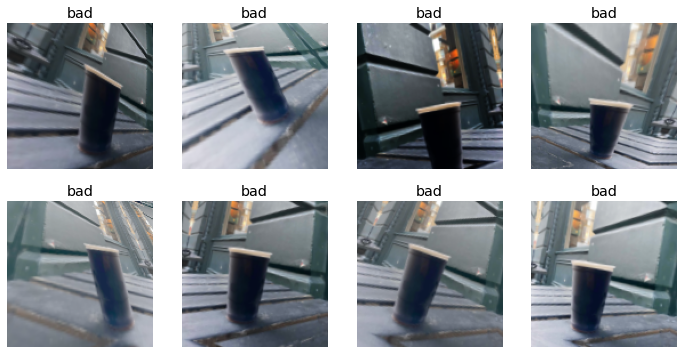

In [61]:
pints = pints.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pints.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [47]:
pints = pints.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pints.dataloaders(path)

In [48]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.097161,1.372533,0.323077,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.660359,0.968527,0.292308,00:07
1,0.583021,0.589385,0.230769,00:07
2,0.474388,0.466262,0.184615,00:07
3,0.411473,0.383078,0.153846,00:07
4,0.353954,0.398373,0.138462,00:07
5,0.320546,0.424943,0.123077,00:07
6,0.281872,0.419820,0.123077,00:07
7,0.262693,0.411085,0.107692,00:07


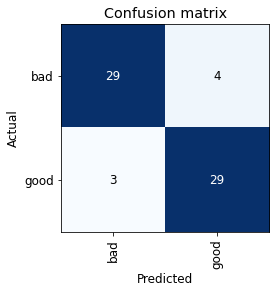

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

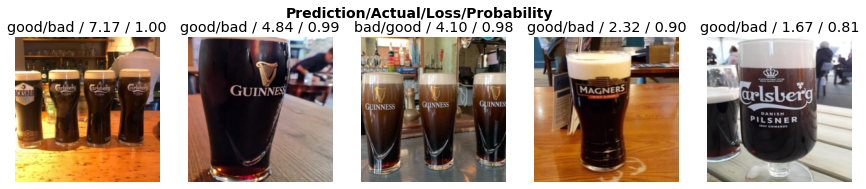

In [50]:
interp.plot_top_losses(5, nrows=1)

In [40]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [43]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Using the Model for Inference

In [51]:
learn.export()

In [52]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [53]:
learn_inf = load_learner(path/'export.pkl')

In [54]:
learn_inf.predict('images/guinness/good/1.jpg')

('good', tensor(1), tensor([0.0010, 0.9990]))

In [55]:
learn_inf.dls.vocab

['bad', 'good']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])